In [1]:

import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

Using TensorFlow backend.


In [2]:
filenames = os.listdir('C:\\Users\\User\\Music\\train1')

categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'mild': 
        categories.append(0)  #The categories are set as labels
    elif category == 'moderate': 
        categories.append(1)
    elif category == 'Verymild':
        categories.append(2)
        
df = pd.DataFrame({
    'filename': filenames,  
    'category': categories,    
})

df

,filename,category
0,mild.1.jpg,0
1,mild.10.jpg,0
2,mild.100.jpg,0
3,mild.1000.jpg,0
4,mild.101.jpg,0
...,...,...
2995,Verymild.995.jpg,2
2996,Verymild.996.jpg,2
2997,Verymild.997.jpg,2
2998,Verymild.998.jpg,2


1    1000
2    1000
0    1000
Name: category, dtype: int64

 Total images:  3000


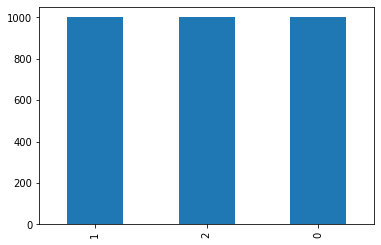

In [3]:
df['category'].value_counts().plot.bar()
print(df['category'].value_counts())

print("\n Total images: ", df.shape[0])

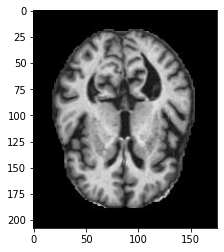

In [4]:
sample = random.choice(filenames)
image = load_img('C:\\Users\\User\\Music\\train1\\'+sample)
plt.imshow(image)

In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model2 = Sequential()

model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150,150, 3)))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Flatten())
model2.add(Dense(96, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(3, activation='softmax')) # 3 because we have car, dog and cat classes

model2.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 82944)            

In [6]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001) 
callbacks = [earlystop, learning_rate_reduction]


In [7]:
df["category"] = df["category"].replace({ 0: 'mild', 1: 'moderate', 2: 'Verymild' })

In [8]:
df["category"].head()

0    mild
1    mild
2    mild
3    mild
4    mild
Name: category, dtype: object

Verymild    824
moderate    813
mild        763
Name: category, dtype: int64

 Total train images:  2400


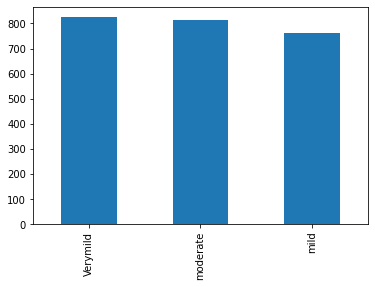

In [9]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=0) 

# Lets see total 'TRAIN' files and in each category
train_df = train_df.reset_index(drop=True)

train_df['category'].value_counts().plot.bar()
print(train_df['category'].value_counts())
print("\n Total train images: ", train_df.shape[0])

mild        237
moderate    187
Verymild    176
Name: category, dtype: int64

 Total validate images:  600


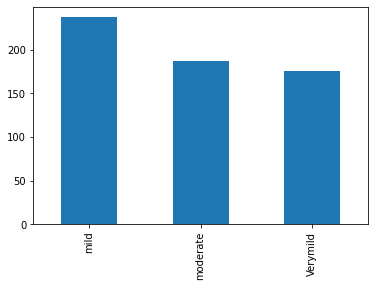

In [10]:
validate_df = validate_df.reset_index(drop=True)
validate_df['category'].value_counts().plot.bar()

print(validate_df['category'].value_counts())
print("\n Total validate images: ", validate_df.shape[0])


In [11]:
total_train = train_df.shape[0]
print("Total train images:", total_train)

total_validate = validate_df.shape[0] 
print("Total validate images:", total_validate)

Total train images: 2400
Total validate images: 600


In [12]:
train_datagen = ImageDataGenerator(
                                    rotation_range=15,
                                    rescale=1./255,
                                    shear_range=0.1,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "C:\\Users\\User\\Music\\train1\\",  
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical',
    batch_size=32
)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "C:\\Users\\User\\Music\\train1\\", 
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical',
    batch_size=32
)

Found 2400 validated image filenames belonging to 3 classes.
Found 600 validated image filenames belonging to 3 classes.


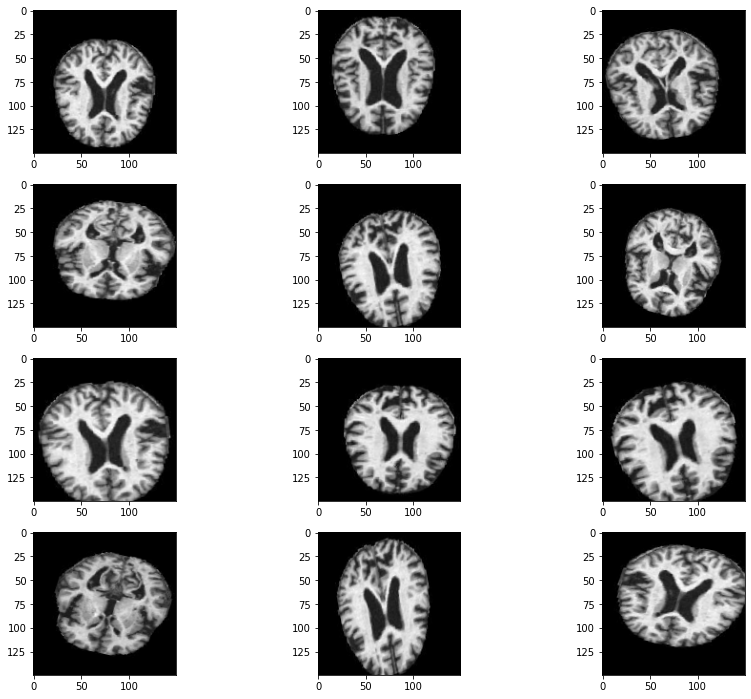

In [13]:

plt.figure(figsize=(12, 12))
for i in range(0, 12):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [14]:
epochs=50
batch_size=50

history = model2.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate/batch_size,
    steps_per_epoch=total_train/batch_size,
    callbacks=callbacks
)

Epoch 1/50
48/48 [==============================] - 56s 1s/step - loss: 1.4468 - accuracy: 0.3568 - val_loss: 1.0975 - val_accuracy: 0.3099
Epoch 2/50
48/48 [==============================] - 40s 834ms/step - loss: 1.0931 - accuracy: 0.3802 - val_loss: 1.0666 - val_accuracy: 0.2713
Epoch 3/50
48/48 [==============================] - 25s 525ms/step - loss: 1.0334 - accuracy: 0.4609 - val_loss: 0.9761 - val_accuracy: 0.7318
Epoch 4/50
48/48 [==============================] - 25s 521ms/step - loss: 0.8731 - accuracy: 0.6074 - val_loss: 0.7773 - val_accuracy: 0.6064
Epoch 5/50
48/48 [==============================] - 24s 501ms/step - loss: 0.7317 - accuracy: 0.6921 - val_loss: 0.4686 - val_accuracy: 0.7473
Epoch 6/50
48/48 [==============================] - 21s 430ms/step - loss: 0.6391 - accuracy: 0.7344 - val_loss: 0.5442 - val_accuracy: 0.7005
Epoch 7/50
48/48 [==============================] - 23s 469ms/step - loss: 0.6192 - accuracy: 0.7513 - val_loss: 0.6051 - val_accuracy: 0.7234
Ep

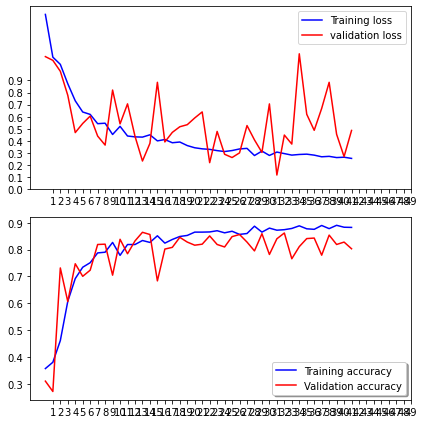

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,6))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.legend()

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.legend()

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [28]:
model2.save('alzheimers.hdf5')

from keras import models    
model = models.load_model('alzheimers.hdf5', compile = False)

In [29]:
test_filenames = os.listdir("C:\\Users\\User\\Music\\Test")
test_df = pd.DataFrame({
    'filename': test_filenames
})

In [30]:
total_test = test_df.shape[0]  
print("Total amount of test images are:", total_test)

Total amount of test images are: 41


In [31]:
test_datagen = ImageDataGenerator(rescale=1./255)
batch_size = 15

test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    "sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("C:\\Users\\User\\Desktop\\datatest\\"+filename, target_size=(150,150)) #rescale(1./255)
    plt.subplot(9, 3, index+1)      
    plt.imshow(img)
    plt.xlabel(filename + "\n Predicted is " + "{}".format(category))
plt.tight_layout()
plt.show()
",
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(150,150),
    batch_size=batch_size,
    shuffle=False 
)

SyntaxError: EOL while scanning string literal (<ipython-input-31-e2e4420eb051>, line 6)

In [24]:
predict = model.predict_generator(test_generator, steps=np.ceil(total_test/batch_size))

# Get total predicteed images       

print("Number of predicted images:", len(predict), "\n")

# Get predictions in array
# These are labels 0, 1, 2 (category)
# Use [?:?] to specify range of index in list/array

print("    0:mild          1:moderate       2:Verymild \n\n", predict, "\n")

NameError: name 'test_generator' is not defined

In [ ]:
test_df['category'] = np.argmax(predict, axis=-1) 

# Lets see the some predicted values for each category of images
# Use [?:?] to specify range 

print(test_df['category'][0:3])

In [25]:
print(train_generator.class_indices) 
print(validation_generator.class_indices, "\n")

# Map labels 
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
print(label_map, "\n")

# See the output of mapped labels
print(test_df['category'][0:4], "\n")

# Lets replace letters with words to see better
print(test_df['category'][0:3])

{'Verymild': 0, 'mild': 1, 'moderate': 2}
{'Verymild': 0, 'mild': 1, 'moderate': 2} 



KeyError: 'category'

In [26]:
test_df['category'].value_counts()
print(test_df['category'].value_counts())

# View the above in a bar graph
test_df['category'].value_counts().plot.bar()

# Lets print the total predicted images 
print("\nTotal predicted images:", test_df.shape[0])

KeyError: 'category'

In [27]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("\\"+filename, target_size=(150,150)) #rescale(1./255)
    plt.subplot(9, 3, index+1)      
    plt.imshow(img)
    plt.xlabel(filename + "\n Predicted is " + "{}".format(category))
plt.tight_layout()
plt.show()


KeyError: 'category'

<Figure size 864x1728 with 0 Axes>